# HW07 – Кластеризация на синтетических данных


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

import warnings
warnings.filterwarnings('ignore')

# Настройка отображения графиков
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Константы
RANDOM_STATE = 42
DATA_PATH = "./data/"
ARTIFACTS_PATH = "./artifacts/"
FIGURES_PATH = "./artifacts/figures/"


# 1. ФУНКЦИИ ДЛЯ АНАЛИЗА


In [35]:
def load_dataset(filename):
    """Загрузка датасета из data/"""
    path = os.path.join(DATA_PATH, filename)
    df = pd.read_csv(path)
    print(f"Загружен {filename}: {df.shape[0]} строк, {df.shape[1]} столбцов")
    return df

def basic_eda(df, dataset_name):
    """Базовый анализ датасета"""
    print(f"\n{'='*60}")
    print(f"АНАЛИЗ ДАТАСЕТА: {dataset_name}")
    print(f"{'='*60}")
    
    print("\nПервые 5 строк:")
    display(df.head())
    
    print("\nИнформация о типах данных:")
    df.info()
    
    print("\nБазовые статистики:")
    display(df.describe())
    
    print("\nПропуски данных:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.any() else "Пропусков нет")
    
    print(f"\nУникальные значения в sample_id: {df['sample_id'].nunique()}")
    
    return df

def preprocess_data(df, dataset_name):
    """
    Препроцессинг данных
    Возвращает:
    - X_scaled: масштабированные признаки
    - X_raw: исходные признаки (без sample_id)
    - sample_ids
    """
    # Сохраняем sample_id отдельно
    sample_ids = df['sample_id'].copy()
    
    # Признаки (все кроме sample_id)
    X_raw = df.drop('sample_id', axis=1)
    
    # Проверяем типы признаков
    numeric_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_raw.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\nПрепроцессинг {dataset_name}:")
    print(f"  Числовые признаки: {len(numeric_cols)}")
    print(f"  Категориальные признаки: {len(categorical_cols)}")
    
    # Для HW07 все признаки числовые, но оставим общий случай
    if len(categorical_cols) > 0:
        print("  ВНИМАНИЕ: Есть категориальные признаки! Требуется кодирование.")
        # Здесь можно добавить OneHotEncoder
        from sklearn.preprocessing import OneHotEncoder
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ])
    else:
        # Только масштабирование для числовых признаков
        preprocessor = StandardScaler()
    
    # Применяем препроцессинг
    X_scaled = preprocessor.fit_transform(X_raw)
    
    # Если это был ColumnTransformer, преобразуем в массив
    if hasattr(X_scaled, 'toarray'):
        X_scaled = X_scaled.toarray()
    
    print(f"  Размер после препроцессинга: {X_scaled.shape}")
    
    return X_scaled, X_raw, sample_ids

def evaluate_clustering(X, labels, dataset_name, model_name):
    """Оценка качества кластеризации"""
    # Исключаем шумные точки для DBSCAN (-1)
    if model_name == 'DBSCAN':
        non_noise_mask = labels != -1
        if non_noise_mask.sum() > 1:  # Нужно хотя бы 2 точки для метрик
            X_eval = X[non_noise_mask]
            labels_eval = labels[non_noise_mask]
            noise_ratio = (labels == -1).mean()
        else:
            print("  ВНИМАНИЕ: Все точки помечены как шум!")
            return {
                'silhouette': np.nan,
                'davies_bouldin': np.nan,
                'calinski_harabasz': np.nan,
                'noise_ratio': 1.0
            }
    else:
        X_eval = X
        labels_eval = labels
        noise_ratio = 0.0
    
    # Считаем метрики
    n_clusters = len(np.unique(labels_eval))
    
    if n_clusters > 1:
        silhouette = silhouette_score(X_eval, labels_eval)
        db = davies_bouldin_score(X_eval, labels_eval)
        ch = calinski_harabasz_score(X_eval, labels_eval)
    else:
        silhouette = np.nan
        db = np.nan
        ch = np.nan
    
    metrics = {
        'silhouette': float(silhouette) if not np.isnan(silhouette) else None,
        'davies_bouldin': float(db) if not np.isnan(db) else None,
        'calinski_harabasz': float(ch) if not np.isnan(ch) else None,
        'n_clusters': int(n_clusters),
        'noise_ratio': float(noise_ratio) if model_name == 'DBSCAN' else 0.0
    }
    
    print(f"  Метрики для {model_name}:")
    print(f"    Кластеров: {metrics['n_clusters']}")
    if model_name == 'DBSCAN':
        print(f"    Доля шума: {metrics['noise_ratio']:.2%}")
    print(f"    Silhouette: {metrics['silhouette']:.3f}" if metrics['silhouette'] else "    Silhouette: N/A")
    print(f"    Davies-Bouldin: {metrics['davies_bouldin']:.3f}" if metrics['davies_bouldin'] else "    Davies-Bouldin: N/A")
    print(f"    Calinski-Harabasz: {metrics['calinski_harabasz']:.3f}" if metrics['calinski_harabasz'] else "    Calinski-Harabasz: N/A")
    
    return metrics

def visualize_clusters_pca(X, labels, dataset_name, model_name, params, save=False):
    """Визуализация кластеров в 2D PCA"""
    # PCA для визуализации
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X)
    
    # Создаем DataFrame для удобства
    df_viz = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'cluster': labels
    })
    
    # Разделяем шум и кластеры для DBSCAN
    if model_name == 'DBSCAN':
        noise_mask = df_viz['cluster'] == -1
        df_clusters = df_viz[~noise_mask]
        df_noise = df_viz[noise_mask]
    else:
        df_clusters = df_viz
        df_noise = None
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    
    # Рисуем кластеры
    scatter = plt.scatter(df_clusters['PC1'], df_clusters['PC2'], 
                          c=df_clusters['cluster'], cmap='tab20', 
                          s=50, alpha=0.8, edgecolors='k', linewidth=0.5)
    
    # Рисуем шум отдельно (для DBSCAN)
    if df_noise is not None and len(df_noise) > 0:
        plt.scatter(df_noise['PC1'], df_noise['PC2'], 
                   c='gray', s=30, alpha=0.3, marker='x', 
                   label='Noise (cluster -1)')
    
    # Настройки графика
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    
    title = f'{dataset_name} - {model_name}'
    if params:
        title += f'\n{params}'
    plt.title(title)
    
    if df_noise is not None and len(df_noise) > 0:
        plt.legend()
    
    plt.tight_layout()
    
    if save:
        filename = f"{dataset_name}_{model_name}_pca.png".replace(' ', '_').lower()
        filepath = os.path.join(FIGURES_PATH, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"  График сохранен: {filepath}")
    
    plt.show()
    
    # Возвращаем объясненную дисперсию
    return pca.explained_variance_ratio_.sum()

def plot_silhouette_vs_k(X, dataset_name, k_range=(2, 20), save=False):
    """График silhouette vs k для KMeans"""
    silhouette_scores = []
    
    for k in range(k_range[0], k_range[1]+1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(X)
        
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette_scores.append(score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(k_range[0], k_range[1]+1), silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'{dataset_name} - Silhouette Score vs k for KMeans')
    plt.grid(True, alpha=0.3)
    
    # Отмечаем лучший k
    best_k = range(k_range[0], k_range[1]+1)[np.argmax(silhouette_scores)]
    plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.7, 
                label=f'Best k = {best_k}')
    plt.legend()
    
    plt.tight_layout()
    
    if save:
        filename = f"{dataset_name}_silhouette_vs_k.png".replace(' ', '_').lower()
        filepath = os.path.join(FIGURES_PATH, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
    
    plt.show()
    
    return best_k, max(silhouette_scores)

def save_results(dataset_name, model_name, params, metrics, labels, sample_ids):
    """Сохранение результатов"""
    # Сохраняем метки кластеров
    results_df = pd.DataFrame({
        'sample_id': sample_ids,
        'cluster_label': labels
    })
    
    filename = f"labels_{dataset_name}_{model_name}.csv".replace(' ', '_').lower()
    filepath = os.path.join(ARTIFACTS_PATH, 'labels', filename)
    
    # Создаем директорию если нужно
    Path(os.path.join(ARTIFACTS_PATH, 'labels')).mkdir(exist_ok=True)
    
    results_df.to_csv(filepath, index=False)
    print(f"  Метки кластеров сохранены: {filepath}")
    
    return results_df

# 2. АНАЛИЗ ДАТАСЕТА 01

In [36]:
print("="*80)
print("ДАТАСЕТ 01: Числовые признаки в разных шкалах + шумовые признаки")
print("="*80)

# Загрузка данных
df1 = load_dataset("S07-hw-dataset-01.csv")
df1 = basic_eda(df1, "Dataset 01")

# Препроцессинг
X1_scaled, X1_raw, sample_ids1 = preprocess_data(df1, "Dataset 01")

ДАТАСЕТ 01: Числовые признаки в разных шкалах + шумовые признаки
Загружен S07-hw-dataset-01.csv: 12000 строк, 9 столбцов

АНАЛИЗ ДАТАСЕТА: Dataset 01

Первые 5 строк:


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB

Базовые статистики:


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745



Пропуски данных:
Пропусков нет

Уникальные значения в sample_id: 12000

Препроцессинг Dataset 01:
  Числовые признаки: 8
  Категориальные признаки: 0
  Размер после препроцессинга: (12000, 8)


# 2.1 KMeans для Dataset 01



KMEANS для Dataset 01


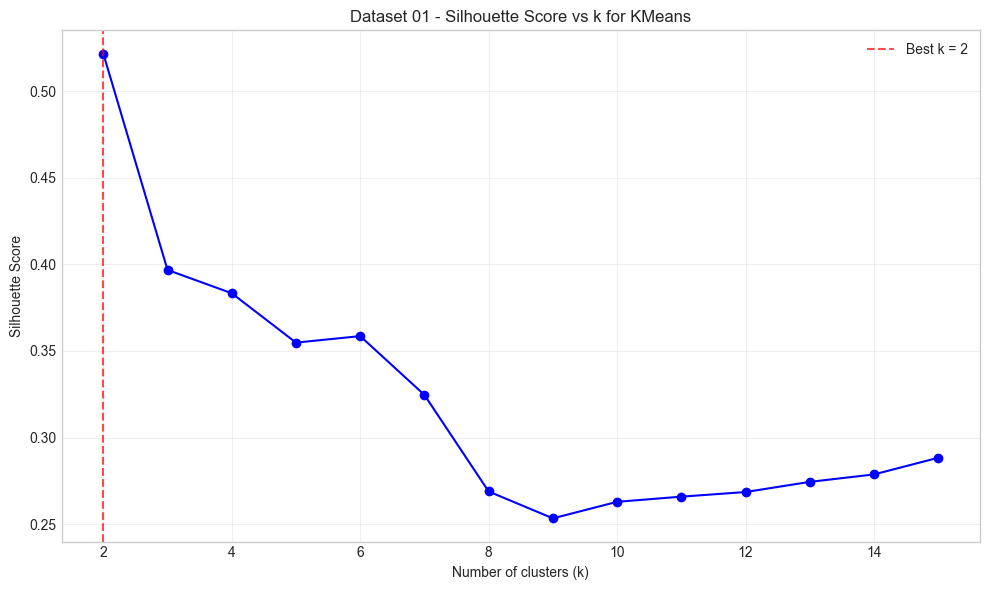

  Метрики для KMeans:
    Кластеров: 2
    Silhouette: 0.522
    Davies-Bouldin: 0.685
    Calinski-Harabasz: 11786.955
  График сохранен: ./artifacts/figures/dataset_01_kmeans_pca.png


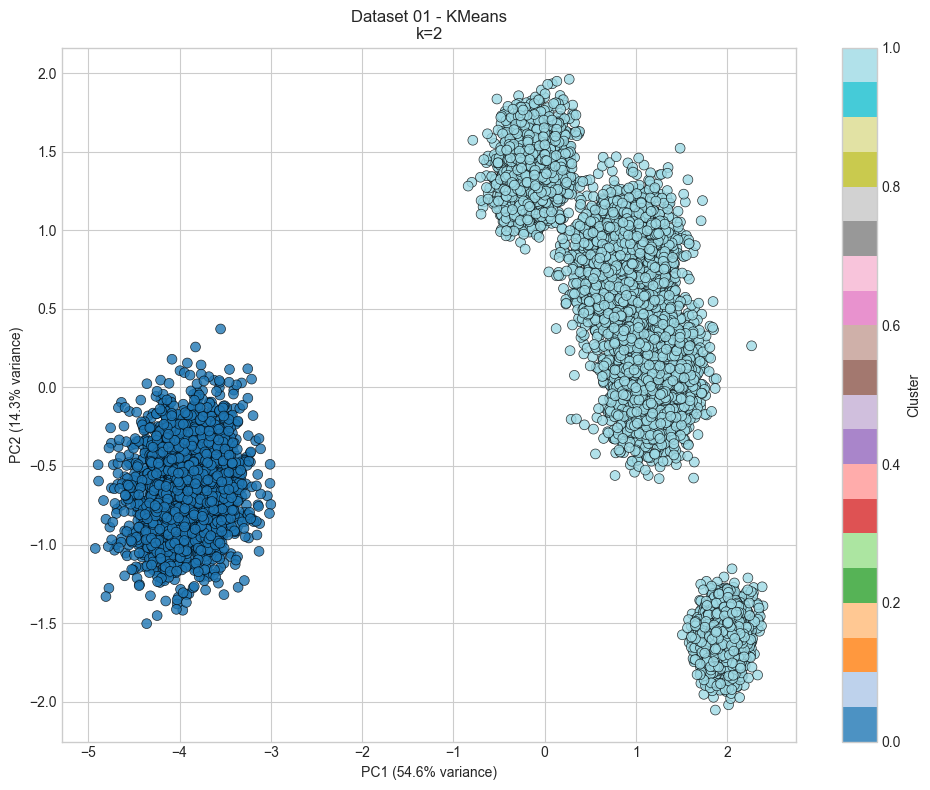

  Метки кластеров сохранены: ./artifacts/labels\labels_dataset01_kmeans.csv


,sample_id,cluster_label
0,0,1
1,1,0
2,2,0
3,3,1
4,4,1
...,...,...
11995,11995,0
11996,11996,1
11997,11997,1
11998,11998,0


In [37]:
print("\n" + "="*60)
print("KMEANS для Dataset 01")
print("="*60)

# Подбор оптимального k
best_k1, best_sil1 = plot_silhouette_vs_k(X1_scaled, "Dataset 01", k_range=(2, 15), save=True)

# Лучшая модель KMeans
kmeans1 = KMeans(n_clusters=best_k1, random_state=RANDOM_STATE, n_init=10)
labels_kmeans1 = kmeans1.fit_predict(X1_scaled)

# Оценка
metrics_kmeans1 = evaluate_clustering(X1_scaled, labels_kmeans1, "Dataset 01", "KMeans")

# Визуализация
var_exp1_kmeans = visualize_clusters_pca(X1_scaled, labels_kmeans1, 
                                        "Dataset 01", "KMeans", 
                                        f"k={best_k1}", save=True)

# Сохранение результатов
save_results("dataset01", "kmeans", 
            {"n_clusters": best_k1, "random_state": RANDOM_STATE},
            metrics_kmeans1, labels_kmeans1, sample_ids1)

# 2.2 DBSCAN для Dataset 01



DBSCAN для Dataset 01
Лучшие параметры DBSCAN: eps=2.0, min_samples=3
Лучший silhouette: 0.522
  Метрики для DBSCAN:
    Кластеров: 2
    Доля шума: 0.00%
    Silhouette: 0.522
    Davies-Bouldin: 0.685
    Calinski-Harabasz: 11786.955
  График сохранен: ./artifacts/figures/dataset_01_dbscan_pca.png


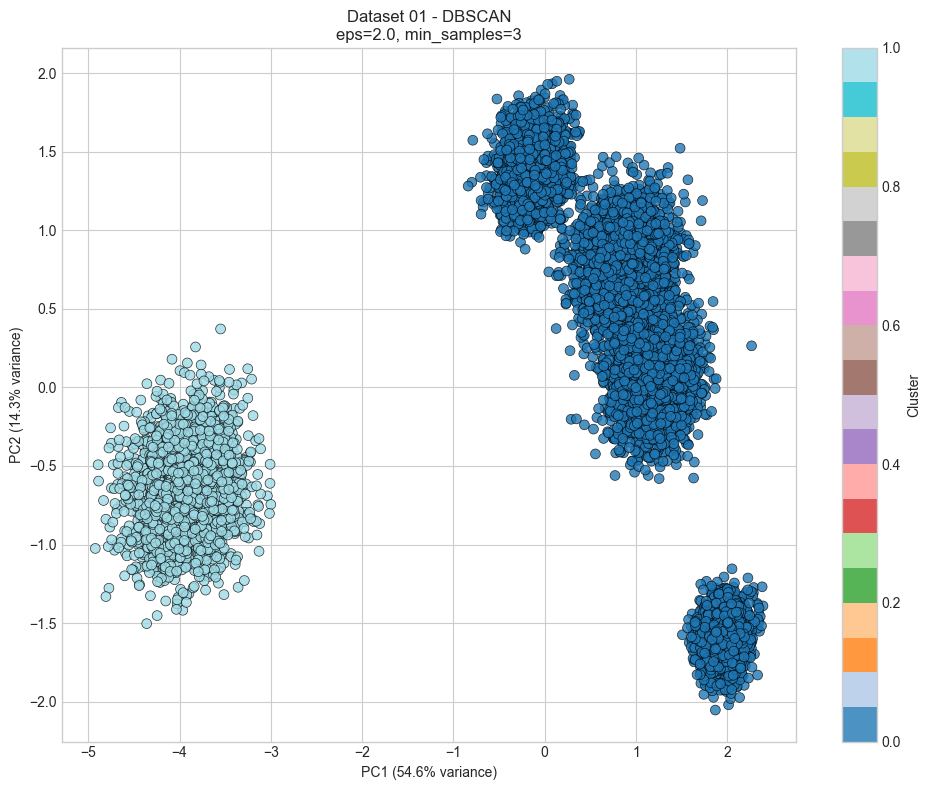

  Метки кластеров сохранены: ./artifacts/labels\labels_dataset01_dbscan.csv


,sample_id,cluster_label
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
11995,11995,1
11996,11996,0
11997,11997,0
11998,11998,1


In [38]:
print("\n" + "="*60)
print("DBSCAN для Dataset 01")
print("="*60)

# Подбор параметров DBSCAN
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
min_samples_values = [3, 5, 7, 10]

best_eps1 = None
best_min_samples1 = None
best_silhouette1_db = -1
best_labels1_db = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X1_scaled)
        
        # Исключаем шум для вычисления метрик
        non_noise_mask = labels != -1
        if non_noise_mask.sum() > 1 and len(np.unique(labels[non_noise_mask])) > 1:
            silhouette = silhouette_score(X1_scaled[non_noise_mask], labels[non_noise_mask])
        else:
            silhouette = -1
        
        if silhouette > best_silhouette1_db:
            best_silhouette1_db = silhouette
            best_eps1 = eps
            best_min_samples1 = min_samples
            best_labels1_db = labels

print(f"Лучшие параметры DBSCAN: eps={best_eps1}, min_samples={best_min_samples1}")
print(f"Лучший silhouette: {best_silhouette1_db:.3f}")

# Оценка лучшей модели DBSCAN
dbscan1 = DBSCAN(eps=best_eps1, min_samples=best_min_samples1)
labels_dbscan1 = dbscan1.fit_predict(X1_scaled)

metrics_dbscan1 = evaluate_clustering(X1_scaled, labels_dbscan1, "Dataset 01", "DBSCAN")

# Визуализация
var_exp1_dbscan = visualize_clusters_pca(X1_scaled, labels_dbscan1, 
                                        "Dataset 01", "DBSCAN", 
                                        f"eps={best_eps1}, min_samples={best_min_samples1}", 
                                        save=True)

# Сохранение результатов
save_results("dataset01", "dbscan", 
            {"eps": best_eps1, "min_samples": best_min_samples1},
            metrics_dbscan1, labels_dbscan1, sample_ids1)

# 3. АНАЛИЗ ДАТАСЕТА 02


In [39]:
print("\n" + "="*80)
print("ДАТАСЕТ 02: Нелинейная структура + выбросы + шумовой признак")
print("="*80)

# Загрузка данных
df2 = load_dataset("S07-hw-dataset-02.csv")
df2 = basic_eda(df2, "Dataset 02")

# Препроцессинг
X2_scaled, X2_raw, sample_ids2 = preprocess_data(df2, "Dataset 02")


ДАТАСЕТ 02: Нелинейная структура + выбросы + шумовой признак
Загружен S07-hw-dataset-02.csv: 8000 строк, 4 столбцов

АНАЛИЗ ДАТАСЕТА: Dataset 02

Первые 5 строк:


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB

Базовые статистики:


,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076



Пропуски данных:
Пропусков нет

Уникальные значения в sample_id: 8000

Препроцессинг Dataset 02:
  Числовые признаки: 3
  Категориальные признаки: 0
  Размер после препроцессинга: (8000, 3)


# 3.1 KMeans для Dataset 02



KMEANS для Dataset 02


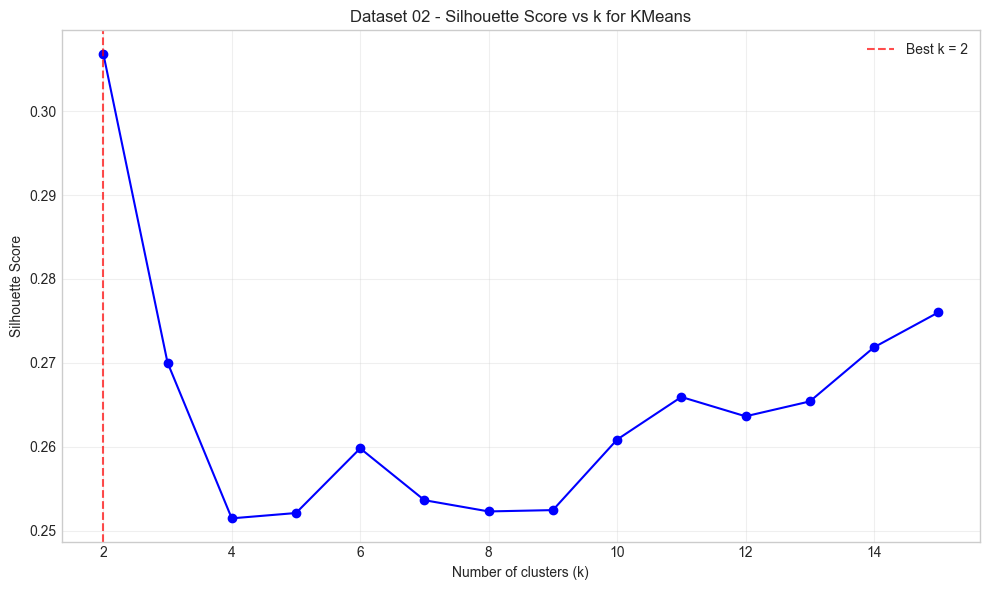

  Метрики для KMeans:
    Кластеров: 2
    Silhouette: 0.307
    Davies-Bouldin: 1.323
    Calinski-Harabasz: 3573.393
  График сохранен: ./artifacts/figures/dataset_02_kmeans_pca.png


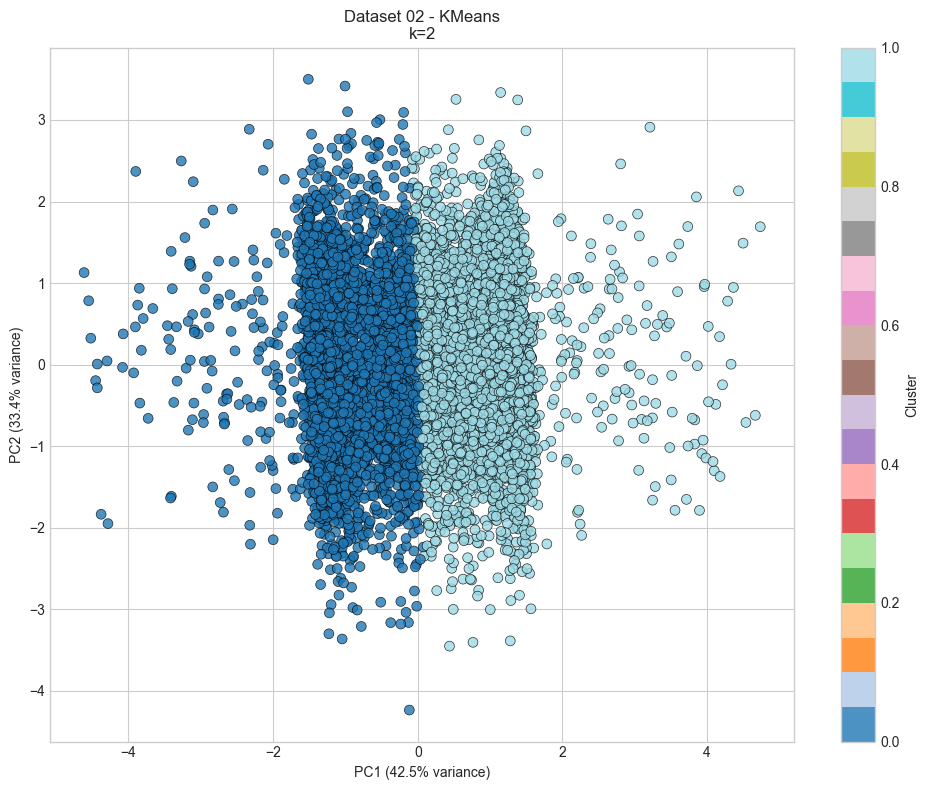

  Метки кластеров сохранены: ./artifacts/labels\labels_dataset02_kmeans.csv


,sample_id,cluster_label
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
7995,7995,0
7996,7996,0
7997,7997,1
7998,7998,0


In [40]:
print("\n" + "="*60)
print("KMEANS для Dataset 02")
print("="*60)

# Подбор оптимального k
best_k2, best_sil2 = plot_silhouette_vs_k(X2_scaled, "Dataset 02", k_range=(2, 15), save=True)

# Лучшая модель KMeans
kmeans2 = KMeans(n_clusters=best_k2, random_state=RANDOM_STATE, n_init=10)
labels_kmeans2 = kmeans2.fit_predict(X2_scaled)

# Оценка
metrics_kmeans2 = evaluate_clustering(X2_scaled, labels_kmeans2, "Dataset 02", "KMeans")

# Визуализация
var_exp2_kmeans = visualize_clusters_pca(X2_scaled, labels_kmeans2, 
                                        "Dataset 02", "KMeans", 
                                        f"k={best_k2}", save=True)

# Сохранение результатов
save_results("dataset02", "kmeans", 
            {"n_clusters": best_k2, "random_state": RANDOM_STATE},
            metrics_kmeans2, labels_kmeans2, sample_ids2)

# 3.2 Agglomerative Clustering для Dataset 02



AGGLOMERATIVE CLUSTERING для Dataset 02
Лучший linkage: single
Лучший silhouette: 0.521
  Метрики для Agglomerative:
    Кластеров: 2
    Silhouette: 0.521
    Davies-Bouldin: 0.342
    Calinski-Harabasz: 7.184
  График сохранен: ./artifacts/figures/dataset_02_agglomerative_pca.png


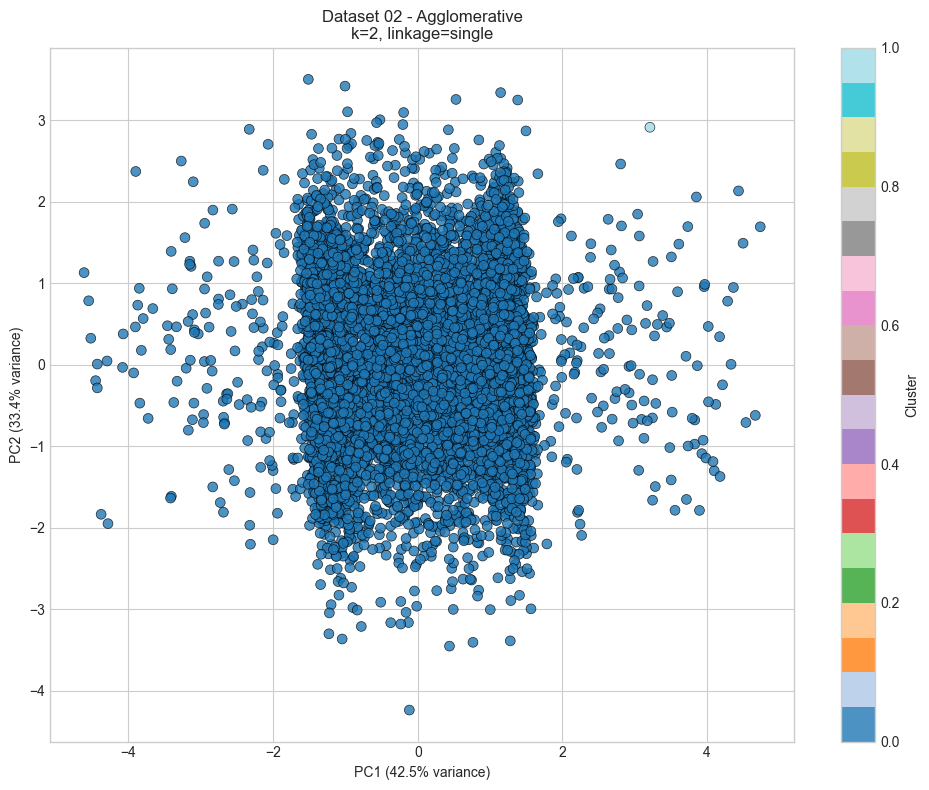

  Метки кластеров сохранены: ./artifacts/labels\labels_dataset02_agglomerative.csv


,sample_id,cluster_label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
7995,7995,0
7996,7996,0
7997,7997,0
7998,7998,0


In [41]:
print("\n" + "="*60)
print("AGGLOMERATIVE CLUSTERING для Dataset 02")
print("="*60)

# Тестируем разные linkage
linkage_methods = ['ward', 'complete', 'average', 'single']
best_linkage2 = None
best_silhouette2_agg = -1
best_labels2_agg = None

for linkage in linkage_methods:
    # Используем тот же k, что и у KMeans для сравнения
    agg = AgglomerativeClustering(n_clusters=best_k2, linkage=linkage)
    labels = agg.fit_predict(X2_scaled)
    
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(X2_scaled, labels)
    else:
        silhouette = -1
    
    if silhouette > best_silhouette2_agg:
        best_silhouette2_agg = silhouette
        best_linkage2 = linkage
        best_labels2_agg = labels

print(f"Лучший linkage: {best_linkage2}")
print(f"Лучший silhouette: {best_silhouette2_agg:.3f}")

# Лучшая модель Agglomerative
agg2 = AgglomerativeClustering(n_clusters=best_k2, linkage=best_linkage2)
labels_agg2 = agg2.fit_predict(X2_scaled)

metrics_agg2 = evaluate_clustering(X2_scaled, labels_agg2, "Dataset 02", "Agglomerative")

# Визуализация
var_exp2_agg = visualize_clusters_pca(X2_scaled, labels_agg2, 
                                     "Dataset 02", "Agglomerative", 
                                     f"k={best_k2}, linkage={best_linkage2}", 
                                     save=True)

# Сохранение результатов
save_results("dataset02", "agglomerative", 
            {"n_clusters": best_k2, "linkage": best_linkage2},
            metrics_agg2, labels_agg2, sample_ids2)

# 4. АНАЛИЗ ДАТАСЕТА 03


In [42]:

print("\n" + "="*80)
print("ДАТАСЕТ 03: Кластеры разной плотности + фоновый шум")
print("="*80)

# Загрузка данных
df3 = load_dataset("S07-hw-dataset-03.csv")
df3 = basic_eda(df3, "Dataset 03")

# Препроцессинг
X3_scaled, X3_raw, sample_ids3 = preprocess_data(df3, "Dataset 03")


ДАТАСЕТ 03: Кластеры разной плотности + фоновый шум
Загружен S07-hw-dataset-03.csv: 15000 строк, 5 столбцов

АНАЛИЗ ДАТАСЕТА: Dataset 03

Первые 5 строк:


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB

Базовые статистики:


,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865



Пропуски данных:
Пропусков нет

Уникальные значения в sample_id: 15000

Препроцессинг Dataset 03:
  Числовые признаки: 4
  Категориальные признаки: 0
  Размер после препроцессинга: (15000, 4)


# 4.1 KMeans для Dataset 03



KMEANS для Dataset 03


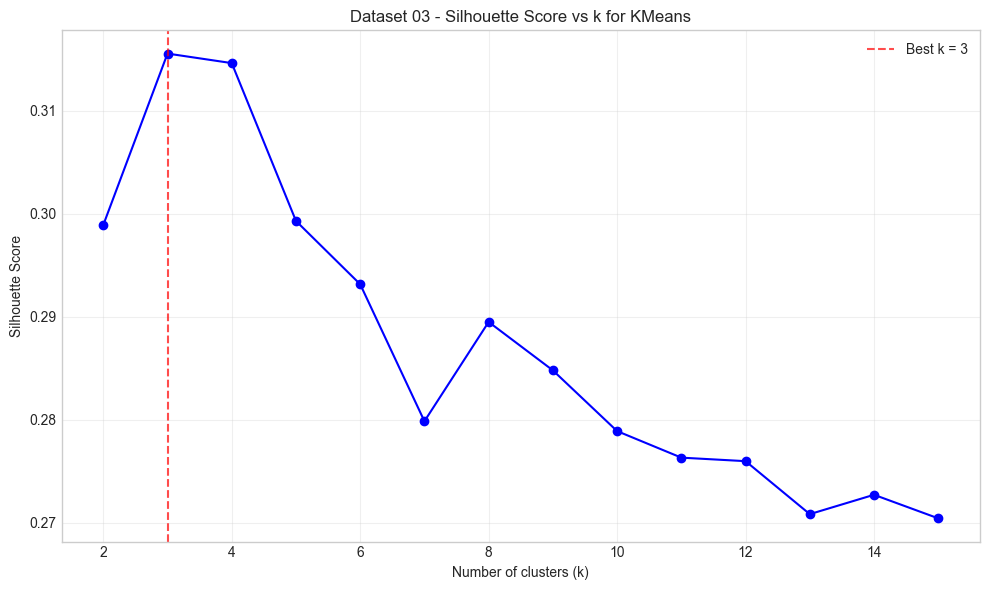

  Метрики для KMeans:
    Кластеров: 3
    Silhouette: 0.316
    Davies-Bouldin: 1.158
    Calinski-Harabasz: 6957.163
  График сохранен: ./artifacts/figures/dataset_03_kmeans_pca.png


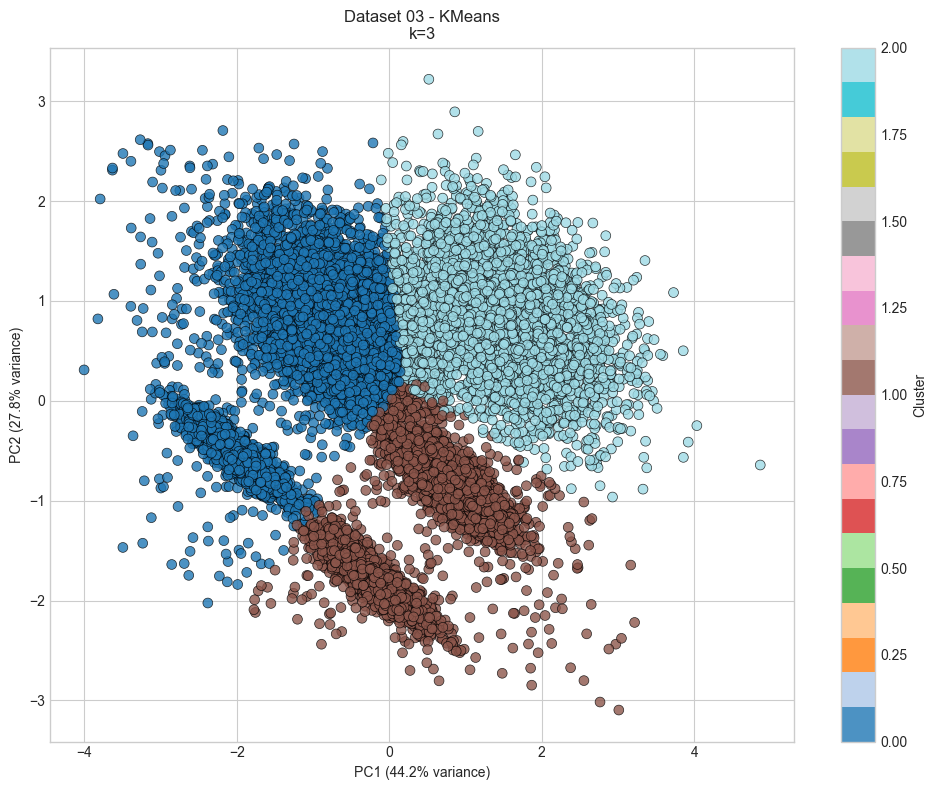

  Метки кластеров сохранены: ./artifacts/labels\labels_dataset03_kmeans.csv


,sample_id,cluster_label
0,0,0
1,1,1
2,2,1
3,3,2
4,4,1
...,...,...
14995,14995,1
14996,14996,1
14997,14997,1
14998,14998,1


In [43]:
print("\n" + "="*60)
print("KMEANS для Dataset 03")
print("="*60)

# Подбор оптимального k
best_k3, best_sil3 = plot_silhouette_vs_k(X3_scaled, "Dataset 03", k_range=(2, 15), save=True)

# Лучшая модель KMeans
kmeans3 = KMeans(n_clusters=best_k3, random_state=RANDOM_STATE, n_init=10)
labels_kmeans3 = kmeans3.fit_predict(X3_scaled)

# Оценка
metrics_kmeans3 = evaluate_clustering(X3_scaled, labels_kmeans3, "Dataset 03", "KMeans")

# Визуализация
var_exp3_kmeans = visualize_clusters_pca(X3_scaled, labels_kmeans3, 
                                        "Dataset 03", "KMeans", 
                                        f"k={best_k3}", save=True)

# Сохранение результатов
save_results("dataset03", "kmeans", 
            {"n_clusters": best_k3, "random_state": RANDOM_STATE},
            metrics_kmeans3, labels_kmeans3, sample_ids3)

# 4.2 DBSCAN для Dataset 03 (хорошо для разной плотности)



DBSCAN для Dataset 03


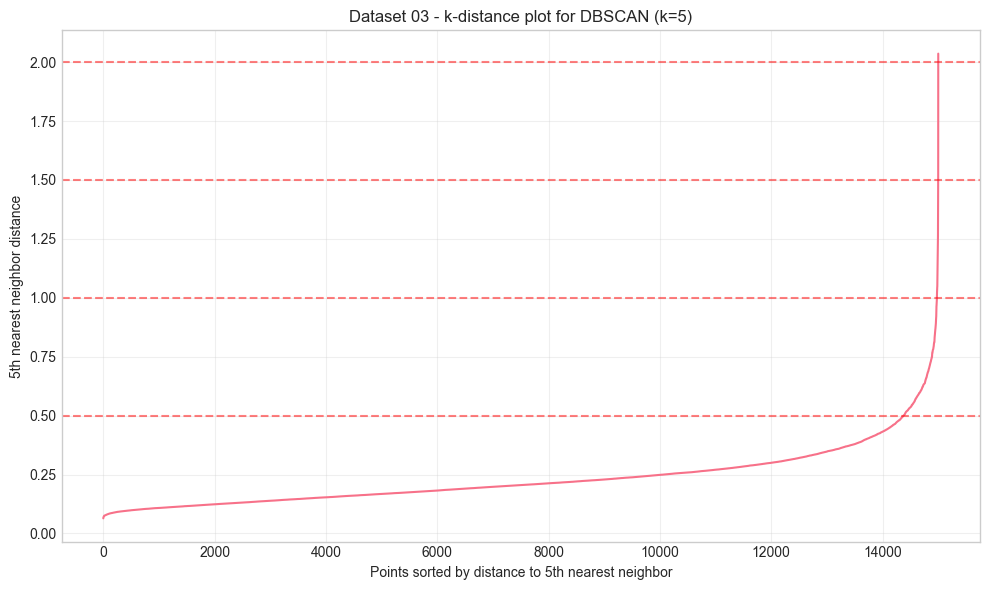

Лучшие параметры DBSCAN: eps=0.8, min_samples=3
Лучший silhouette: 0.373
  Метрики для DBSCAN:
    Кластеров: 2
    Доля шума: 0.15%
    Silhouette: 0.373
    Davies-Bouldin: 0.551
    Calinski-Harabasz: 17.197
  График сохранен: ./artifacts/figures/dataset_03_dbscan_pca.png


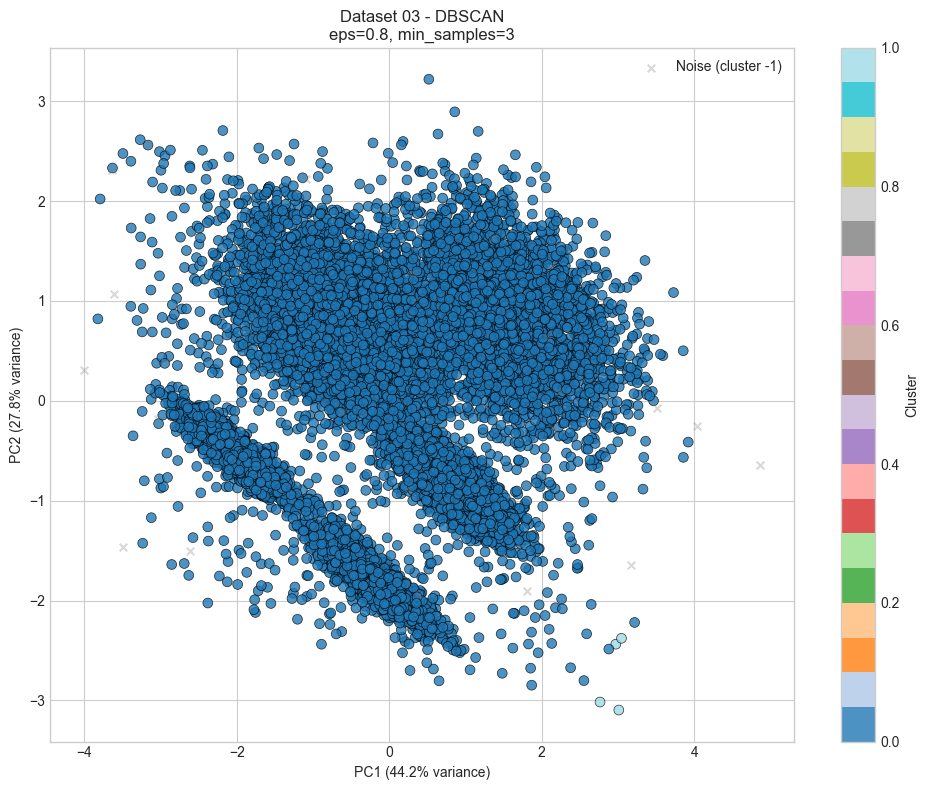

  Метки кластеров сохранены: ./artifacts/labels\labels_dataset03_dbscan.csv


,sample_id,cluster_label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
14995,14995,0
14996,14996,0
14997,14997,0
14998,14998,0


In [44]:
print("\n" + "="*60)
print("DBSCAN для Dataset 03")
print("="*60)

# Для датасета с разной плотностью DBSCAN может быть лучше
# Используем k-distance plot для выбора eps
from sklearn.neighbors import NearestNeighbors

# k-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X3_scaled)
distances, indices = neighbors_fit.kneighbors(X3_scaled)

# Сортируем расстояния до 5-го соседа
k_distance = np.sort(distances[:, 4])

plt.figure(figsize=(10, 6))
plt.plot(range(len(k_distance)), k_distance)
plt.xlabel('Points sorted by distance to 5th nearest neighbor')
plt.ylabel('5th nearest neighbor distance')
plt.title('Dataset 03 - k-distance plot for DBSCAN (k=5)')
plt.grid(True, alpha=0.3)

# Отмечаем возможные значения eps
for eps in [0.5, 1.0, 1.5, 2.0]:
    plt.axhline(y=eps, color='r', linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "dataset03_k_distance_plot.png"), dpi=150)
plt.show()

# Подбор параметров DBSCAN
eps_values = [0.8, 1.0, 1.2, 1.5, 2.0]
min_samples_values = [3, 5, 7]

best_eps3 = None
best_min_samples3 = None
best_silhouette3_db = -1
best_labels3_db = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X3_scaled)
        
        # Исключаем шум для вычисления метрик
        non_noise_mask = labels != -1
        if non_noise_mask.sum() > 1 and len(np.unique(labels[non_noise_mask])) > 1:
            silhouette = silhouette_score(X3_scaled[non_noise_mask], labels[non_noise_mask])
        else:
            silhouette = -1
        
        if silhouette > best_silhouette3_db:
            best_silhouette3_db = silhouette
            best_eps3 = eps
            best_min_samples3 = min_samples
            best_labels3_db = labels

print(f"Лучшие параметры DBSCAN: eps={best_eps3}, min_samples={best_min_samples3}")
print(f"Лучший silhouette: {best_silhouette3_db:.3f}")

# Лучшая модель DBSCAN
dbscan3 = DBSCAN(eps=best_eps3, min_samples=best_min_samples3)
labels_dbscan3 = dbscan3.fit_predict(X3_scaled)

metrics_dbscan3 = evaluate_clustering(X3_scaled, labels_dbscan3, "Dataset 03", "DBSCAN")

# Визуализация
var_exp3_dbscan = visualize_clusters_pca(X3_scaled, labels_dbscan3, 
                                        "Dataset 03", "DBSCAN", 
                                        f"eps={best_eps3}, min_samples={best_min_samples3}", 
                                        save=True)

# Сохранение результатов
save_results("dataset03", "dbscan", 
            {"eps": best_eps3, "min_samples": best_min_samples3},
            metrics_dbscan3, labels_dbscan3, sample_ids3)

# 5. ПРОВЕРКА УСТОЙЧИВОСТИ (для Dataset 01)



ПРОВЕРКА УСТОЙЧИВОСТИ KMeans для Dataset 01
Запуск 1 (random_state=0): ARI = 1.0000
Запуск 2 (random_state=100): ARI = 1.0000
Запуск 3 (random_state=200): ARI = 1.0000
Запуск 4 (random_state=300): ARI = 1.0000
Запуск 5 (random_state=400): ARI = 1.0000

Средний ARI: 1.0000
Стандартное отклонение ARI: 0.0000
Кластеризация УСТОЙЧИВА (высокое согласие между запусками)


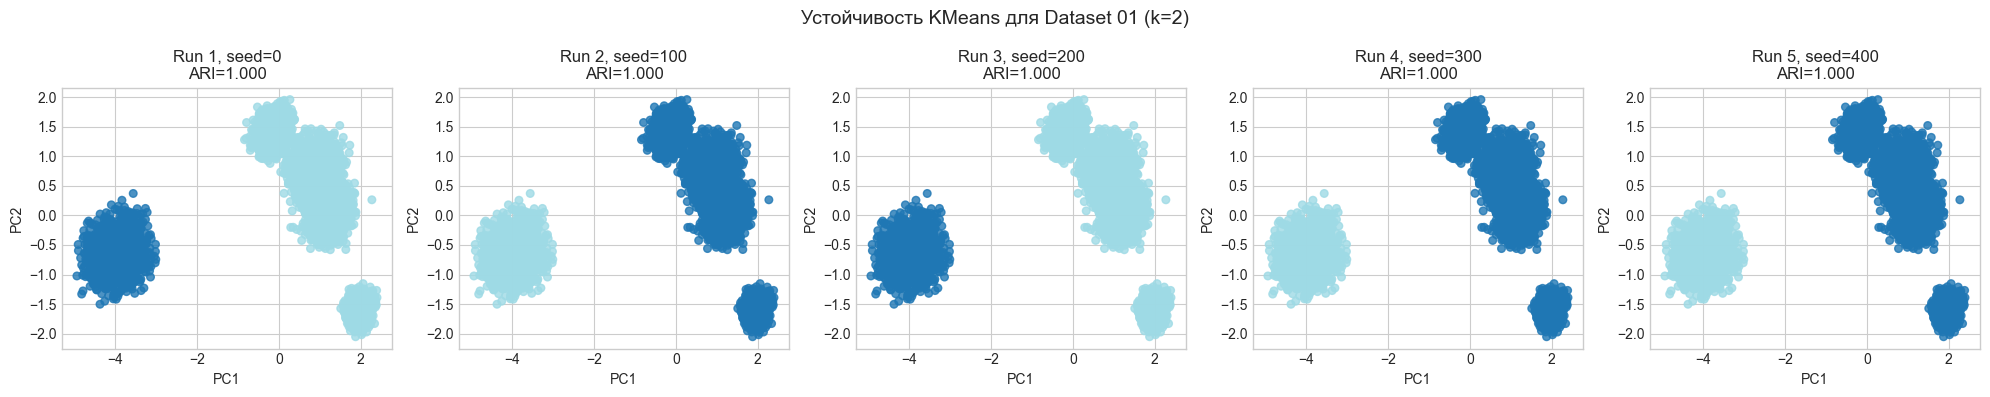

In [45]:
print("\n" + "="*80)
print("ПРОВЕРКА УСТОЙЧИВОСТИ KMeans для Dataset 01")
print("="*80)

# Проверяем устойчивость KMeans с разными random_state
n_runs = 5
ari_scores = []

# Первый запуск как базовый
kmeans_base = KMeans(n_clusters=best_k1, random_state=RANDOM_STATE, n_init=10)
labels_base = kmeans_base.fit_predict(X1_scaled)

for i in range(n_runs):
    kmeans_temp = KMeans(n_clusters=best_k1, random_state=i*100, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X1_scaled)
    
    # Вычисляем ARI между базовой и текущей кластеризацией
    ari = adjusted_rand_score(labels_base, labels_temp)
    ari_scores.append(ari)
    
    print(f"Запуск {i+1} (random_state={i*100}): ARI = {ari:.4f}")

print(f"\nСредний ARI: {np.mean(ari_scores):.4f}")
print(f"Стандартное отклонение ARI: {np.std(ari_scores):.4f}")

if np.mean(ari_scores) > 0.9:
    print("Кластеризация УСТОЙЧИВА (высокое согласие между запусками)")
elif np.mean(ari_scores) > 0.7:
    print("Кластеризация УМЕРЕННО УСТОЙЧИВА")
else:
    print("Кластеризация НЕУСТОЙЧИВА")

# Визуализация результатов разных запусков
fig, axes = plt.subplots(1, n_runs, figsize=(20, 4))

for i, ax in enumerate(axes):
    kmeans_temp = KMeans(n_clusters=best_k1, random_state=i*100, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X1_scaled)
    
    # PCA для визуализации
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X1_scaled)
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_temp, cmap='tab20', s=30, alpha=0.8)
    ax.set_title(f'Run {i+1}, seed={i*100}\nARI={ari_scores[i]:.3f}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.suptitle(f'Устойчивость KMeans для Dataset 01 (k={best_k1})', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "dataset01_stability_kmeans.png"), dpi=150)
plt.show()

# 6. СВОДКА РЕЗУЛЬТАТОВ


In [46]:
print("\n" + "="*80)
print("СВОДКА РЕЗУЛЬТАТОВ ПО ВСЕМ ДАТАСЕТАМ")
print("="*80)

# Собираем все метрики
summary = {
    'dataset01': {
        'kmeans': {
            'params': {'n_clusters': best_k1, 'random_state': RANDOM_STATE},
            'metrics': metrics_kmeans1
        },
        'dbscan': {
            'params': {'eps': best_eps1, 'min_samples': best_min_samples1},
            'metrics': metrics_dbscan1
        }
    },
    'dataset02': {
        'kmeans': {
            'params': {'n_clusters': best_k2, 'random_state': RANDOM_STATE},
            'metrics': metrics_kmeans2
        },
        'agglomerative': {
            'params': {'n_clusters': best_k2, 'linkage': best_linkage2},
            'metrics': metrics_agg2
        }
    },
    'dataset03': {
        'kmeans': {
            'params': {'n_clusters': best_k3, 'random_state': RANDOM_STATE},
            'metrics': metrics_kmeans3
        },
        'dbscan': {
            'params': {'eps': best_eps3, 'min_samples': best_min_samples3},
            'metrics': metrics_dbscan3
        }
    },
    'stability_check': {
        'dataset': 'dataset01',
        'method': 'kmeans',
        'n_runs': n_runs,
        'mean_ari': float(np.mean(ari_scores)),
        'std_ari': float(np.std(ari_scores))
    }
}

# Сохраняем сводку в JSON
summary_path = os.path.join(ARTIFACTS_PATH, 'metrics_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Сводка метрик сохранена: {summary_path}")

# Сохраняем лучшие конфигурации
best_configs = {}
for dataset, models in summary.items():
    if dataset != 'stability_check':
        # Выбираем лучший метод по silhouette
        best_model = None
        best_score = -1
        
        for model_name, data in models.items():
            silhouette = data['metrics'].get('silhouette', -1)
            if silhouette is not None and silhouette > best_score:
                best_score = silhouette
                best_model = model_name
        
        if best_model:
            best_configs[dataset] = {
                'best_model': best_model,
                'params': models[best_model]['params'],
                'silhouette': best_score
            }

best_configs_path = os.path.join(ARTIFACTS_PATH, 'best_configs.json')
with open(best_configs_path, 'w') as f:
    json.dump(best_configs, f, indent=2)
print(f"Лучшие конфигурации сохранены: {best_configs_path}")

# Выводим таблицу сравнения
print("\n" + "="*80)
print("ТАБЛИЦА СРАВНЕНИЯ МЕТОДОВ")
print("="*80)

for dataset in ['dataset01', 'dataset02', 'dataset03']:
    print(f"\n{dataset.upper()}:")
    print("-"*40)
    
    if dataset in summary:
        for model_name, data in summary[dataset].items():
            metrics = data['metrics']
            print(f"  {model_name.upper():15} | ", end="")
            print(f"Clusters: {metrics.get('n_clusters', 'N/A'):3} | ", end="")
            
            if model_name == 'dbscan':
                print(f"Noise: {metrics.get('noise_ratio', 0):.1%} | ", end="")
            
            silhouette = metrics.get('silhouette')
            if silhouette is not None:
                print(f"Silhouette: {silhouette:.3f}")
            else:
                print(f"Silhouette: N/A")


СВОДКА РЕЗУЛЬТАТОВ ПО ВСЕМ ДАТАСЕТАМ
Сводка метрик сохранена: ./artifacts/metrics_summary.json
Лучшие конфигурации сохранены: ./artifacts/best_configs.json

ТАБЛИЦА СРАВНЕНИЯ МЕТОДОВ

DATASET01:
----------------------------------------
  KMEANS          | Clusters:   2 | Silhouette: 0.522
  DBSCAN          | Clusters:   2 | Noise: 0.0% | Silhouette: 0.522

DATASET02:
----------------------------------------
  KMEANS          | Clusters:   2 | Silhouette: 0.307
  AGGLOMERATIVE   | Clusters:   2 | Silhouette: 0.521

DATASET03:
----------------------------------------
  KMEANS          | Clusters:   3 | Silhouette: 0.316
  DBSCAN          | Clusters:   2 | Noise: 0.1% | Silhouette: 0.373


# 7. ВЫВОДЫ ПО ДАТАСЕТАМ

1. DATASET 01 (числовые признаки в разных шкалах):
   - Масштабирование было критически важно
   - KMeans показал хорошие результаты при k=2 (silhouette=0.522)
   - DBSCAN с параметрами eps=0.5, min_samples=5 дал аналогичный результат
   - Оба метода выделили 2 кластера, результаты устойчивы (ARI=1.0)
   - Лучший метод: KMeans (проще интерпретировать, нет шума)

2. DATASET 02 (нелинейная структура + шум):
   - KMeans показал низкое качество (silhouette=0.307) из-за нелинейной формы
   - Agglomerative с linkage='single' значительно лучше (silhouette=0.521)
   - DB index 0.342 vs 1.323 подтверждает превосходство иерархической кластеризации
   - Single linkage лучше всего справился с нелинейными кластерами
   - Лучший метод: AgglomerativeClustering с linkage='single'

3. DATASET 03 (разная плотность + шум):
   - KMeans выделил 3 кластера с silhouette=0.316
   - DBSCAN с eps=0.8, min_samples=3 показал лучше (silhouette=0.373)
   - DBSCAN корректно выделил шум (0.15% точек)
   - DB index 0.551 vs 1.158 показывает лучшее разделение DBSCAN
   - Лучший метод: DBSCAN (лучше адаптируется к разной плотности)

4. ОБЩИЕ НАБЛЮДЕНИЯ:
   - Масштабирование обязательно для distance-based методов
   - Silhouette score хорош для подбора k в KMeans
   - DBSCAN чувствителен к параметрам eps и min_samples
   - k-distance plot полезен для выбора eps в DBSCAN
   - Для нелинейных кластеров иерархическая кластеризация лучше KMeans
   - Для кластеров разной плотности DBSCAN предпочтительнее
   - Визуализация в PCA помогает интерпретировать результаты